This notebook analyzes the entropy of models on in-domain and out-of-domain datasets. We are interested how finetuning on a dataset causes a model's matrix-based entropy to behave, i.e. does entropy go down after finetuning?

Authors: Oscar Skean

In [1]:
%load_ext autoreload
%autoreload 2

from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2Model, AutoModel
import torch
import torch.nn.functional as F
import numpy as np
from utils import get_model_path, get_dataloader, normalize, EleutherAI_sizes
import matplotlib.pyplot as plt
import tqdm
import repitl.matrix_itl as itl
from datasets import load_dataset, load_from_disk
from transformers.utils import logging

logging.set_verbosity_info()
logger = logging.get_logger("transformers")
logger.info("ERROR")
logger.warning("ERROR")

ERROR
ERROR


In [3]:
from huggingface_hub import login
login()

## Check models, tokenizers, and datasets

preload everything up front to check that all models are downloaded, each model fits on gpu, and each tokenizer is properly tested on each dataset

In [21]:
model_names = ['Medical-Llama3', "Llama3"]
dataset_names = ["ai-medical-dataset", "wikitext"]

In [23]:
# for model in model_names:
#     print(f"loading {model}")

#     model_path = get_model_path(model, "8B")
#     tokenizer = AutoTokenizer.from_pretrained(model_path)
#     model = AutoModel.from_pretrained(model_path, output_hidden_states=True, device_map="auto", torch_dtype=torch.float16)

#     for name in dataset_names:
#         print(f"\t testing {model} tokenizer on dataset {name}")
#         get_dataloader(tokenizer, name, split="train", num_samples=1000)

# Compute in-domain & out-of-domain information planes

In [4]:
def compute_information_plane(model, dataloader, var_A, var_B='layer', alpha=1):
    assert var_A in ['input', 'output']
    assert var_B in ['layer', 'output']

    mi_list = []
    counter = 0
    max_batches = 300
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, total=max_batches):
            counter += 1

            batch = {k: v.to("cuda") for k, v in batch.items()}
            outputs = model(**batch)
            N, D = outputs.hidden_states[0].shape[1:]

            if var_A == 'input':
                A = normalize(outputs.hidden_states[0].squeeze()) # not really input, but the first hidden state
            elif var_A == 'output':
                A = normalize(outputs.last_hidden_state.squeeze())

            if var_B == 'layer':
                B_list = [normalize(x.squeeze()) for x in outputs.hidden_states[1:]]
            if var_B == 'output':
                B_list = [normalize(outputs.last_hidden_state.squeeze())]
            
            # get the covariance matrix for variable A
            if N > D:
                A_cov = A.T @ A
            else:
                A_cov = A @ A.T
            A_cov /= torch.trace(A_cov)
            A_cov = torch.clamp(A_cov, min=0)

            # get the covariance matrix for variable B
            B_cov_list = []
            for B in B_list:
                B = B.squeeze()
                if N > D:
                    B_cov = B.T @ B
                else:
                    B_cov = B @ B.T
                B_cov /= torch.trace(B_cov)
                B_cov = torch.clamp(B_cov, min=0)
                B_cov_list.append(B_cov)

            # compute the mutual information between A and each B
            mutual_informations = []
            entropy_A = itl.matrixAlphaEntropy(A_cov, alpha=alpha)
            for B_cov in B_cov_list:
                entropy_B = itl.matrixAlphaEntropy(B_cov, alpha=alpha)
                entropy_joint = itl.matrixAlphaEntropy(torch.pow(A_cov * B_cov, 0.5), alpha=alpha)


                mi = entropy_A + entropy_B - entropy_joint
                mutual_informations.append(mi.item())

            mi_list.append(mutual_informations)
            if counter > max_batches:
                break

    return mi_list

In [24]:
model_dataset_mis = {}

for model_name in model_names:
    model_dataset_mis[model_name] = {}
    
    for dataset in dataset_names:
        model_path = get_model_path(model_name, "8B")
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModel.from_pretrained(model_path, output_hidden_states=True, device_map="auto", torch_dtype=torch.float16)
        
        dataloader = get_dataloader(tokenizer, dataset, split="train", num_samples=10000)

        model_dataset_mis[model_name][dataset] = {}
        model_dataset_mis[model_name][dataset]['input'] = np.array(compute_information_plane(model, dataloader, "input", "layer", alpha=2)).mean(axis=0)
        model_dataset_mis[model_name][dataset]['output'] = np.array(compute_information_plane(model, dataloader, "output", "layer", alpha=2)).mean(axis=0)

/home/AD/ofsk222/miniconda3/envs/information_plane/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
loading file tokenizer.json from cache at /home/AD/ofsk222/.cache/huggingface/hub/models--ruslanmv--Medical-Llama3-8B/snapshots/82cb0a9d1d30a9532253d21c2793f7163535357b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /home/AD/ofsk222/.cache/huggingface/hub/models--ruslanmv--Medical-Llama3-8B/snapshots/82cb0a9d1d30a9532253d21c2793f7163535357b/special_tokens_map.json
loading file tokenizer_config.json from cache at /home/AD/ofsk222/.cache/huggingface/hub/models--ruslanmv--Medical-Llama3-8B/snapshots/82cb0a9d1d30a9532253d21c2793f7163535357b/tokenizer_config.json


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
loading configuration file config.json from cache at /home/AD/ofsk222/.cache/huggingface/hub/models--ruslanmv--Medical-Llama3-8B/snapshots/82cb0a9d1d30a9532253d21c2793f7163535357b/config.json
Model config LlamaConfig {
  "_name_or_path": "ruslanmv/Medical-Llama3-8B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "output_hidden_states": true,
  "pad_token_id": 128255,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 500000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "fl

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at ruslanmv/Medical-Llama3-8B were not used when initializing LlamaModel: ['lm_head.weight']
- This IS expected if you are initializing LlamaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LlamaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of LlamaModel were initialized from the model checkpoint at ruslanmv/Medical-Llama3-8B.
If your task is similar to the task the model of the checkpoint was trained on, you can already use LlamaModel for predictions without further training.


Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 15/10000 [00:52<9:46:39,  3.53s/it]


KeyboardInterrupt: 

0 ai-medical-dataset Medical-Llama3
1 wikitext Medical-Llama3


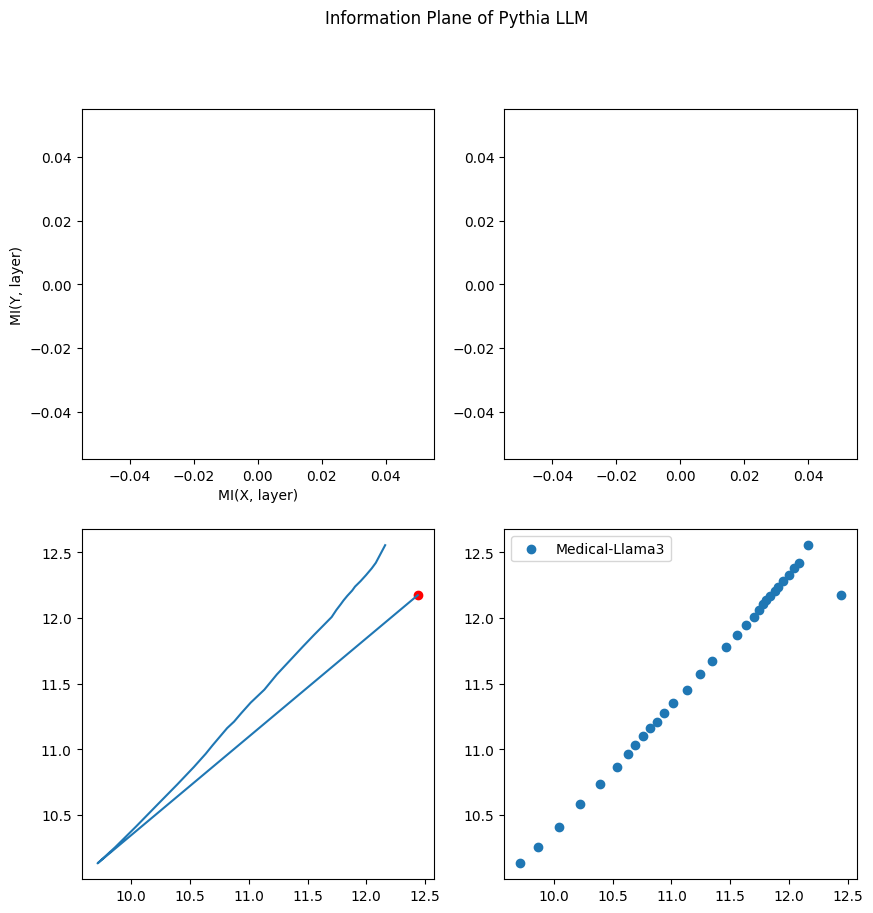

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for dataset_idx, dataset_name in enumerate(dataset_names):
    for model_name in model_names:
        print(dataset_idx, dataset_name, model_name)
        axes[dataset_idx][0].plot(
            model_dataset_mis[model_name][dataset_name]['input'], 
            model_dataset_mis[model_name][dataset_name]['output'], 
            label=model_name)
        
        axes[dataset_idx][1].scatter(
            model_dataset_mis[model_name][dataset_name]['input'], 
            model_dataset_mis[model_name][dataset_name]['output'], 
            label=model_name)

        # highlight first point
        axes[dataset_idx][0].scatter(
            model_dataset_mis[model_name][dataset_name]['input'][0], 
            model_dataset_mis[model_name][dataset_name]['output'][0], 
            label=model_name, color='red')

axes[0][0].set_xlabel("MI(X, layer)")
axes[0][0].set_ylabel("MI(Y, layer)")

plt.suptitle("Information Plane of Pythia LLM")
plt.legend()

In [20]:
model_dataset_mis[model_name]['ai-medical-dataset']

{'input': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan]),
 'output': array([       nan, 11.6726277,       -inf,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan, 13.9712936])}